In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np


In [34]:
# Get the current working directory
print("Current working directory:", os.getcwd())

# Use absolute path
data_path = Path("/home/rizfn/github/babel-transition/src/dataAnalysis/grambank/data/cldf")

# Load the main tables into pandas DataFrames
languages_df = pd.read_csv(data_path / "languages.csv")
parameters_df = pd.read_csv(data_path / "parameters.csv") 
values_df = pd.read_csv(data_path / "values.csv")
codes_df = pd.read_csv(data_path / "codes.csv")

# Display basic info about the datasets
print("Languages table shape:", languages_df.shape)
print("Parameters table shape:", parameters_df.shape)
print("Values table shape:", values_df.shape)
print("Codes table shape:", codes_df.shape)

# Show first few rows
print("\nLanguages columns:", languages_df.columns.tolist())
print("Parameters columns:", parameters_df.columns.tolist())
print("Values columns:", values_df.columns.tolist())
print("Codes columns:", codes_df.columns.tolist())

Current working directory: /home/rizfn/github/babel-transition/src/dataAnalysis/grambank
Languages table shape: (2467, 13)
Parameters table shape: (195, 12)
Values table shape: (441663, 9)
Codes table shape: (398, 4)

Languages columns: ['ID', 'Name', 'Macroarea', 'Latitude', 'Longitude', 'Glottocode', 'ISO639P3code', 'provenance', 'Family_name', 'Family_level_ID', 'Language_level_ID', 'level', 'lineage']
Parameters columns: ['ID', 'Name', 'Description', 'ColumnSpec', 'Patrons', 'Grambank_ID_desc', 'Boundness', 'Flexivity', 'Gender_or_Noun_Class', 'Locus_of_Marking', 'Word_Order', 'Informativity']
Values columns: ['ID', 'Language_ID', 'Parameter_ID', 'Value', 'Code_ID', 'Comment', 'Source', 'Source_comment', 'Coders']
Codes columns: ['ID', 'Parameter_ID', 'Name', 'Description']


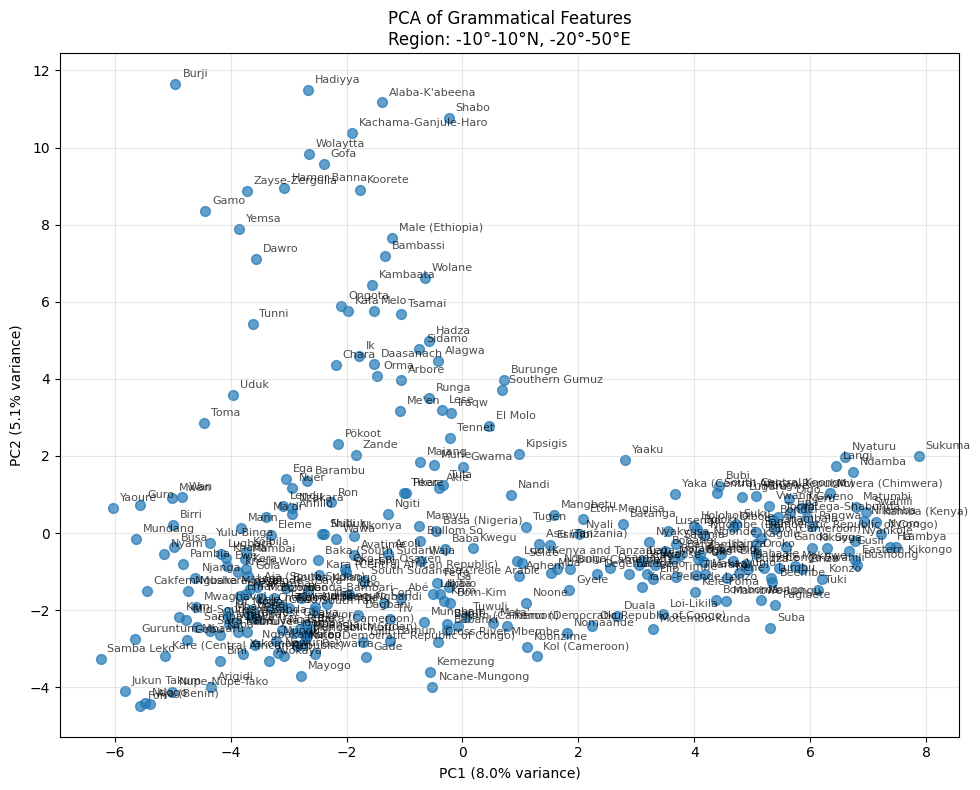

In [40]:
# Define your geographic region (lat/lon bounds)
lat_min, lat_max = -10, 10    # Example: equatorial region
lon_min, lon_max = -20, 50    # Example: Africa roughly

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Create the plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, s=50)

# Add language labels
for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    plt.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title(f'PCA of Grammatical Features\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
plt.grid(True, alpha=0.3)
plt.tight_layout()

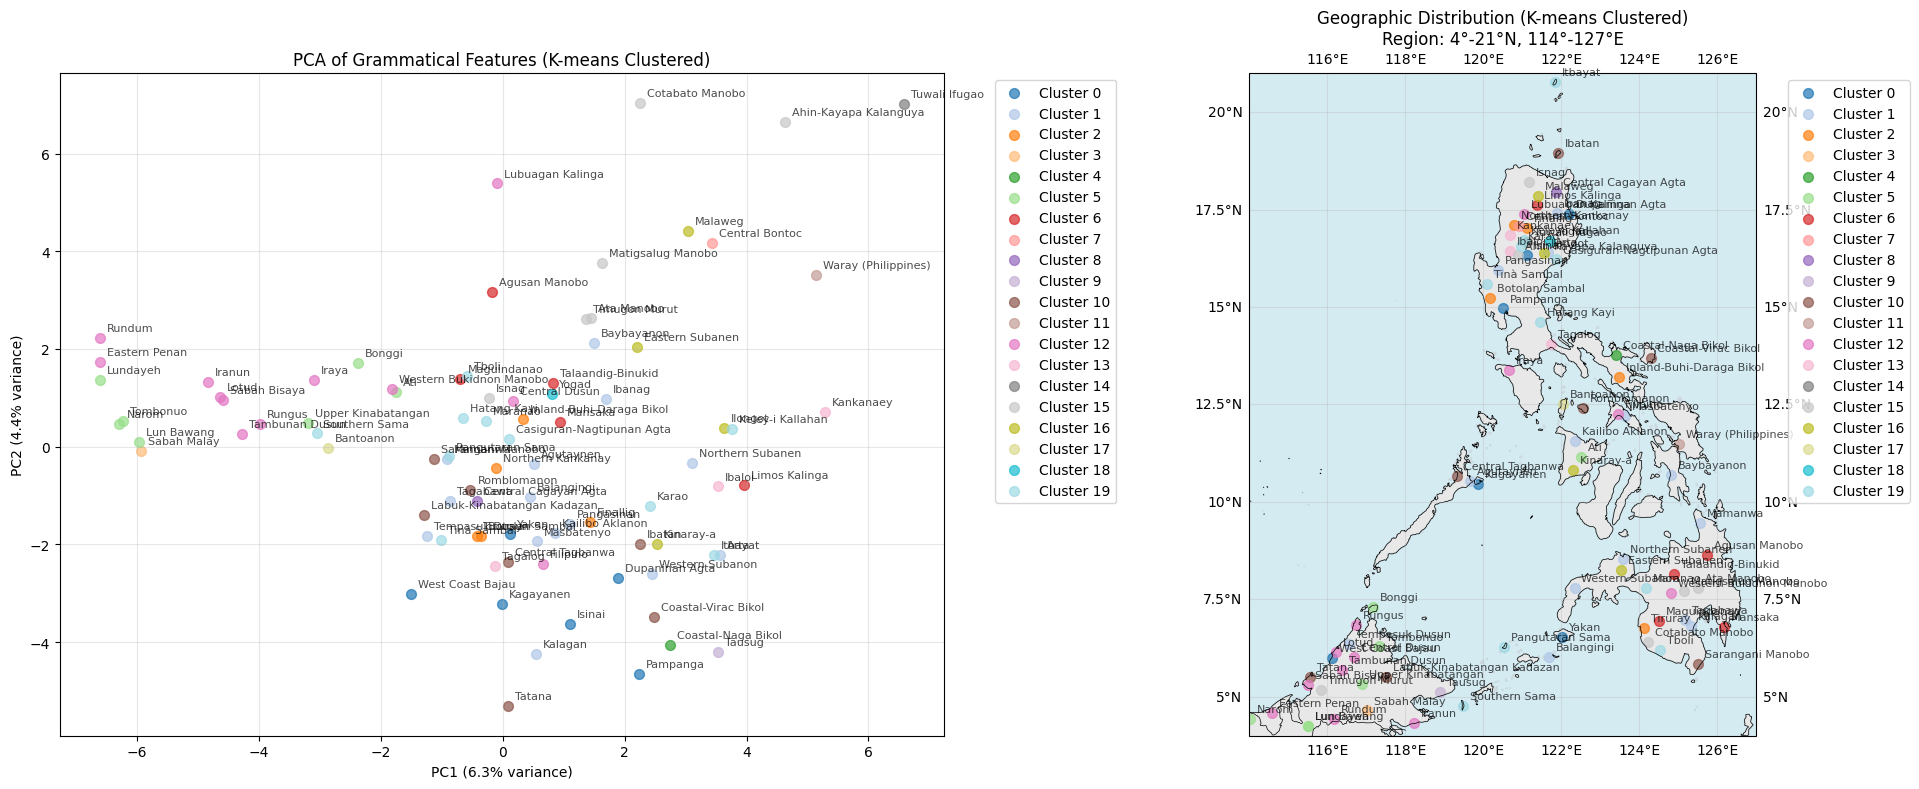

In [41]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Define your geographic region (lat/lon bounds)
lat_min, lat_max = 4, 21
lon_min, lon_max = 114, 127

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Get unique clusters and assign colors using a colormap that works well for many categories
unique_clusters = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))  # tab20 has 20 distinct colors
cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}


# Create subplot layout with cartopy projection
fig = plt.figure(figsize=(20, 8))

# Plot 1: PCA with clusters (same as before)
ax1 = fig.add_subplot(1, 2, 1)
for cluster in unique_clusters:
    mask = clusters == cluster
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}')

for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    ax1.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA of Grammatical Features (K-means Clustered)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Geographic plot with coastlines
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

# Add gridlines
ax2.gridlines(draw_labels=True, alpha=0.3)

# Plot language points
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_coords = lang_coords[mask]
    
    ax2.scatter(cluster_coords['Longitude'], cluster_coords['Latitude'], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}',
               transform=ccrs.PlateCarree())

# Add language labels
for i, row in lang_coords.iterrows():
    ax2.annotate(row['Name'], (row['Longitude'], row['Latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7,
                transform=ccrs.PlateCarree())

# Set extent to your region
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax2.set_title(f'Geographic Distribution (K-means Clustered)\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

/home/rizfn/github/babel-transition/babel-env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/rizfn/github/babel-transition/babel-env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/rizfn/github/babel-transition/babel-env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/rizfn/github/babel-transition/babel-env/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  w

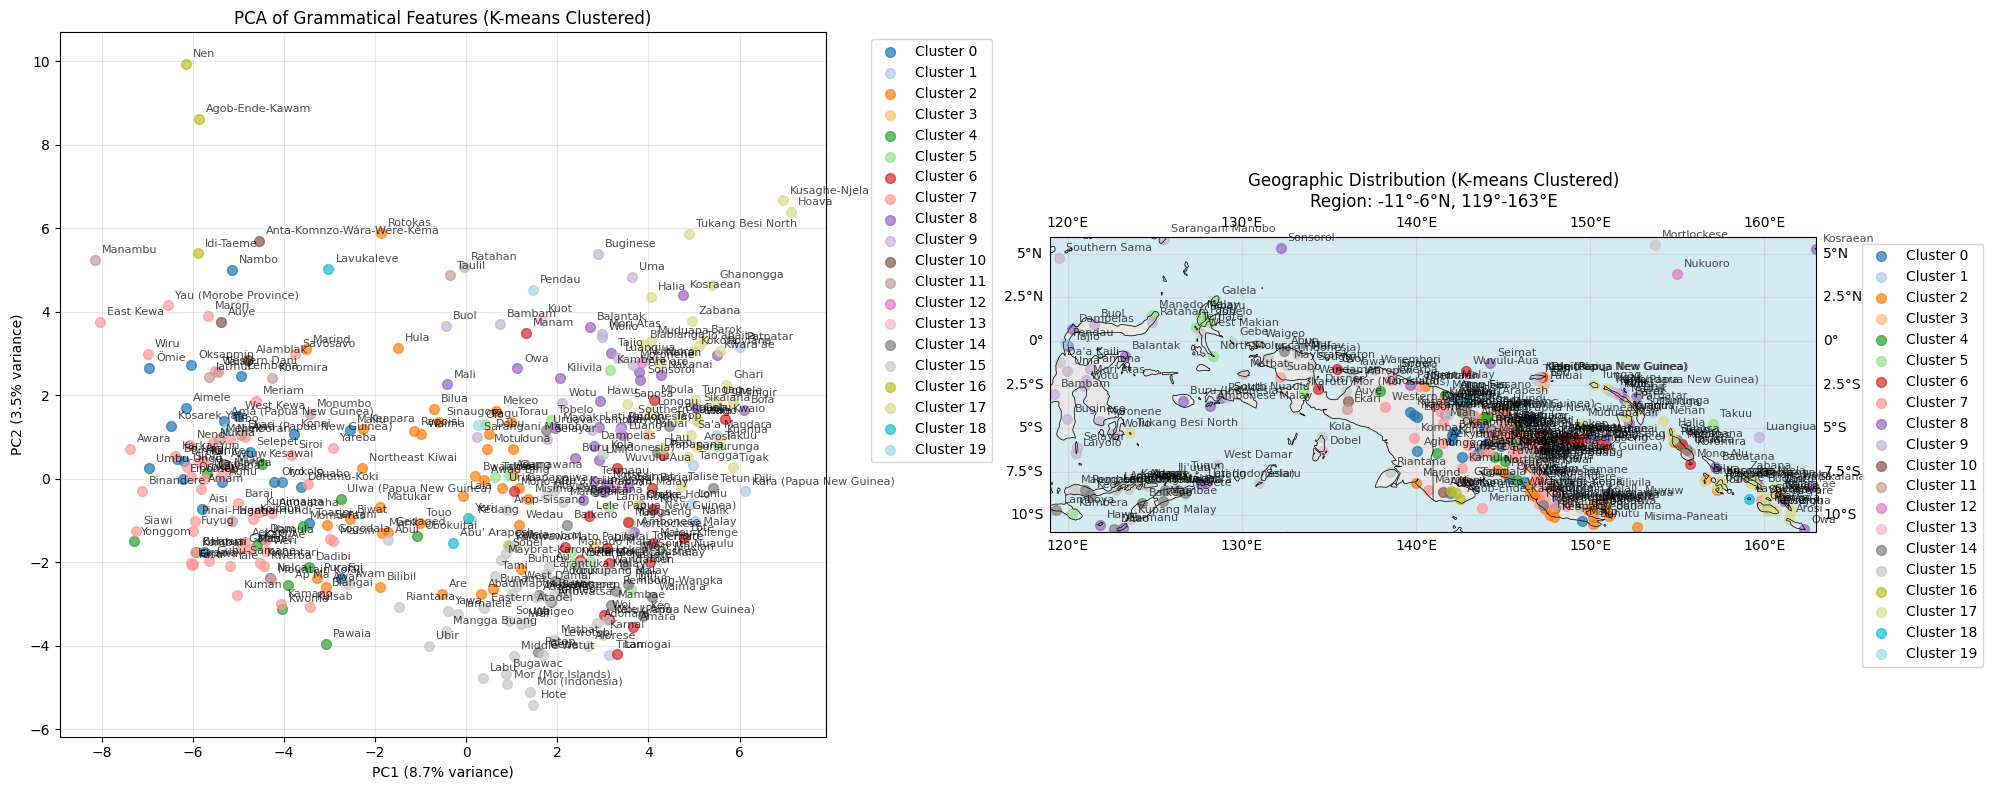

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Define your geographic region (lat/lon bounds)
lat_min, lat_max = -11, 6
lon_min, lon_max = 119, 163

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Create lang_coords for languages that are in our feature matrix
lang_coords = geo_languages[geo_languages['ID'].isin(feature_matrix.index)].copy()
lang_coords = lang_coords.set_index('ID').loc[feature_matrix.index].reset_index()

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Get unique clusters and assign colors using a colormap that works well for many categories
unique_clusters = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))  # tab20 has 20 distinct colors
cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Create subplot layout with cartopy projection
fig = plt.figure(figsize=(20, 8))

# Plot 1: PCA with clusters
ax1 = fig.add_subplot(1, 2, 1)
for cluster in unique_clusters:
    mask = clusters == cluster
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}')

for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    ax1.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA of Grammatical Features (K-means Clustered)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Geographic plot with coastlines
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

# Add gridlines
ax2.gridlines(draw_labels=True, alpha=0.3)

# Plot language points
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_coords = lang_coords[mask]
    
    ax2.scatter(cluster_coords['Longitude'], cluster_coords['Latitude'], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}',
               transform=ccrs.PlateCarree())

# Add language labels
for i, row in lang_coords.iterrows():
    ax2.annotate(row['Name'], (row['Longitude'], row['Latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7,
                transform=ccrs.PlateCarree())

# Set extent to your region
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax2.set_title(f'Geographic Distribution (K-means Clustered)\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


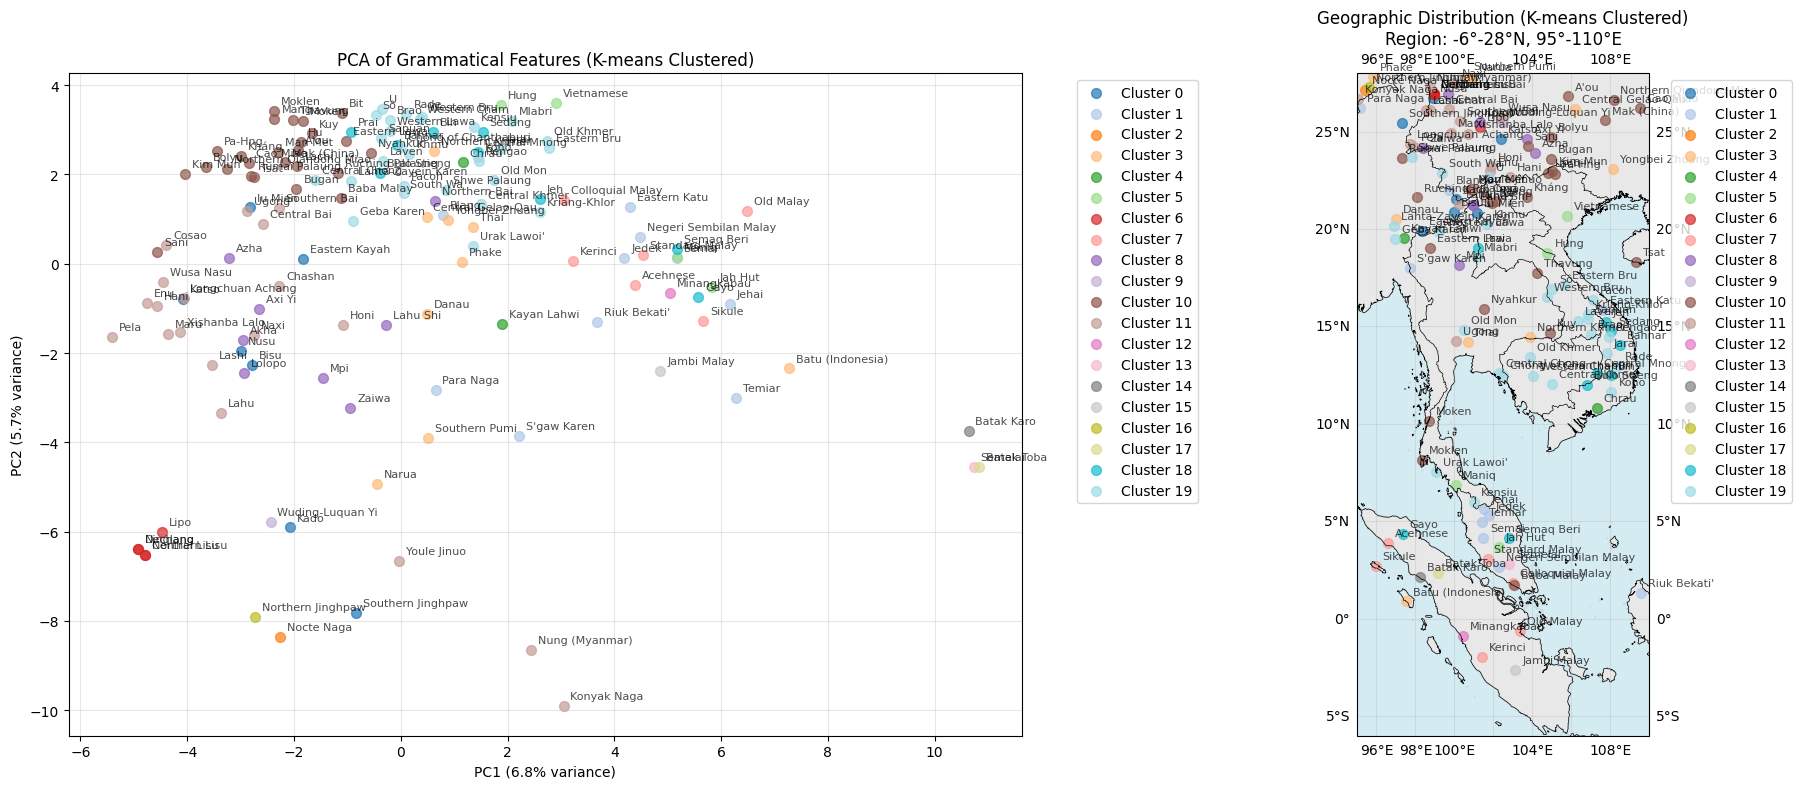

In [45]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

# Define your geographic region (lat/lon bounds)
lat_min, lat_max = -6, 28
lon_min, lon_max = 95, 110

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Create lang_coords for languages that are in our feature matrix
lang_coords = geo_languages[geo_languages['ID'].isin(feature_matrix.index)].copy()
lang_coords = lang_coords.set_index('ID').loc[feature_matrix.index].reset_index()

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=20, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Get unique clusters and assign colors using a colormap that works well for many categories
unique_clusters = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))  # tab20 has 20 distinct colors
cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Create subplot layout with cartopy projection
fig = plt.figure(figsize=(20, 8))

# Plot 1: PCA with clusters
ax1 = fig.add_subplot(1, 2, 1)
for cluster in unique_clusters:
    mask = clusters == cluster
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}')

for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    ax1.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA of Grammatical Features (K-means Clustered)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Geographic plot with coastlines
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

# Add gridlines
ax2.gridlines(draw_labels=True, alpha=0.3)

# Plot language points
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_coords = lang_coords[mask]
    
    ax2.scatter(cluster_coords['Longitude'], cluster_coords['Latitude'], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}',
               transform=ccrs.PlateCarree())

# Add language labels
for i, row in lang_coords.iterrows():
    ax2.annotate(row['Name'], (row['Longitude'], row['Latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7,
                transform=ccrs.PlateCarree())

# Set extent to your region
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax2.set_title(f'Geographic Distribution (K-means Clustered)\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
